## Question Answering with a fine-tuned BERT on CoQA dataset

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install transformers

import torch
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\matth\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip
C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading

In [2]:
coqa = pd.read_json('http://downloads.cs.stanford.edu/nlp/data/coqa/coqa-train-v1.0.json')
coqa.head()

,version,data
0,1,"{'source': 'wikipedia', 'id': '3zotghdk5ibi9ce..."
1,1,"{'source': 'cnn', 'id': '3wj1oxy92agboo5nlq4r7..."
2,1,"{'source': 'gutenberg', 'id': '3bdcf01ogxu7zdn..."
3,1,"{'source': 'cnn', 'id': '3ewijtffvo7wwchw6rtya..."
4,1,"{'source': 'gutenberg', 'id': '3urfvvm165iantk..."


### Data cleaning

In [3]:
del coqa["version"]

In [4]:
cols = ["text","question","answer"]

# j = 1
comp_list = []
for index, row in coqa.iterrows():
    for i in range(len(row["data"]["questions"])):
        temp_list = []
#         temp_list.append(j)
        temp_list.append(row["data"]["story"])
        temp_list.append(row["data"]["questions"][i]["input_text"])
        temp_list.append(row["data"]["answers"][i]["input_text"])
        comp_list.append(temp_list)
#     j += 1
new_df = pd.DataFrame(comp_list, columns=cols) 

### Saving the data as csv

In [5]:
new_df.to_csv("CoQA_data.csv", index=False)

### Loading the data

In [6]:
data = pd.read_csv("CoQA_data.csv")
data.head()

,text,question,answer
0,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475
1,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research
2,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law"
3,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology"
4,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project


In [7]:
print("Number of question and answers: ", len(data))

Number of question and answers:  108647


### Building the chatbot

In [8]:
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
random_num = np.random.randint(0,len(data))

question = data["question"][random_num]
text = data["text"][random_num]

In [10]:
print(question, "\n", text)

What does EDM stand for? 
 Electronica is an umbrella term that encompasses a broad group of electronic-based styles such as techno, house, ambient, drum and bass, jungle, and industrial dance, among others. It has been used to describe the rise of electronic music styles intended not just for dancing but also concentrated listening. 

In North America, in the late 1990s, the mainstream music industry adopted and to some extent manufactured "electronica" as an umbrella term encompassing styles such as techno, big beat, drum and bass, trip hop, downtempo, and ambient, regardless of whether it was curated by indie labels catering to the "underground" nightclub and rave scenes, or licensed by major labels and marketed to mainstream audiences as a commercially viable alternative to alternative rock music. By the late 2000s, however, the industry abandoned "electronica" in favor of "electronic dance music" (EDM), a term with roots in academia and an increasing association with outdoor music

In [11]:
input_ids = tokenizer.encode(question, text)
print("The input has a total of {} tokens.".format(len(input_ids)))

The input has a total of 327 tokens.


In [12]:
tokens = tokenizer.convert_ids_to_tokens(input_ids)

for token, id in zip(tokens, input_ids):
    print('{:8}{:8,}'.format(token,id))

[CLS]        101
what       2,054
does       2,515
ed         3,968
##m        2,213
stand      3,233
for        2,005
?          1,029
[SEP]        102
electronic   4,816
##a        2,050
is         2,003
an         2,019
umbrella  12,977
term       2,744
that       2,008
encompasses  13,974
a          1,037
broad      5,041
group      2,177
of         1,997
electronic   4,816
-          1,011
based      2,241
styles     6,782
such       2,107
as         2,004
techno    21,416
,          1,010
house      2,160
,          1,010
ambient   17,093
,          1,010
drum       6,943
and        1,998
bass       3,321
,          1,010
jungle     8,894
,          1,010
and        1,998
industrial   3,919
dance      3,153
,          1,010
among      2,426
others     2,500
.          1,012
it         2,009
has        2,038
been       2,042
used       2,109
to         2,000
describe   6,235
the        1,996
rise       4,125
of         1,997
electronic   4,816
music      2,189
styles     6,782
int

In [13]:
#first occurence of [SEP] token
sep_idx = input_ids.index(tokenizer.sep_token_id)
print(sep_idx)

#number of tokens in segment A - question
num_seg_a = sep_idx+1
print(num_seg_a)

#number of tokens in segment B - text
num_seg_b = len(input_ids) - num_seg_a
print(num_seg_b)

segment_ids = [0]*num_seg_a + [1]*num_seg_b
print(segment_ids)

assert len(segment_ids) == len(input_ids)

8
9
318
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [14]:
#token input_ids to represent the input
#token segment_ids to differentiate our segments - text and question 
output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
#print(output.start_logits, output.end_logits)

In [15]:
#tokens with highest start and end scores
answer_start = torch.argmax(output.start_logits)
answer_end = torch.argmax(output.end_logits)
#print(answer_start, answer_end)

In [16]:
if answer_end >= answer_start:
    answer = " ".join(tokens[answer_start:answer_end+1])
else:
    print("I am unable to find the answer to this question. Can you please ask another question?")
    
print("Text:\n{}".format(text.capitalize()))
print("\nQuestion:\n{}".format(question.capitalize()))
print("\nAnswer:\n{}.".format(answer.capitalize()))

Text:
Electronica is an umbrella term that encompasses a broad group of electronic-based styles such as techno, house, ambient, drum and bass, jungle, and industrial dance, among others. it has been used to describe the rise of electronic music styles intended not just for dancing but also concentrated listening. 

in north america, in the late 1990s, the mainstream music industry adopted and to some extent manufactured "electronica" as an umbrella term encompassing styles such as techno, big beat, drum and bass, trip hop, downtempo, and ambient, regardless of whether it was curated by indie labels catering to the "underground" nightclub and rave scenes, or licensed by major labels and marketed to mainstream audiences as a commercially viable alternative to alternative rock music. by the late 2000s, however, the industry abandoned "electronica" in favor of "electronic dance music" (edm), a term with roots in academia and an increasing association with outdoor music festivals and relati

### Visualization of the tokens

In [17]:
start_scores = output.start_logits.detach().numpy().flatten()
end_scores = output.end_logits.detach().numpy().flatten()

token_labels = []
for i, token in enumerate(tokens):
    token_labels.append("{}-{}".format(token,i))

In [18]:
# print(len(token_labels))

327


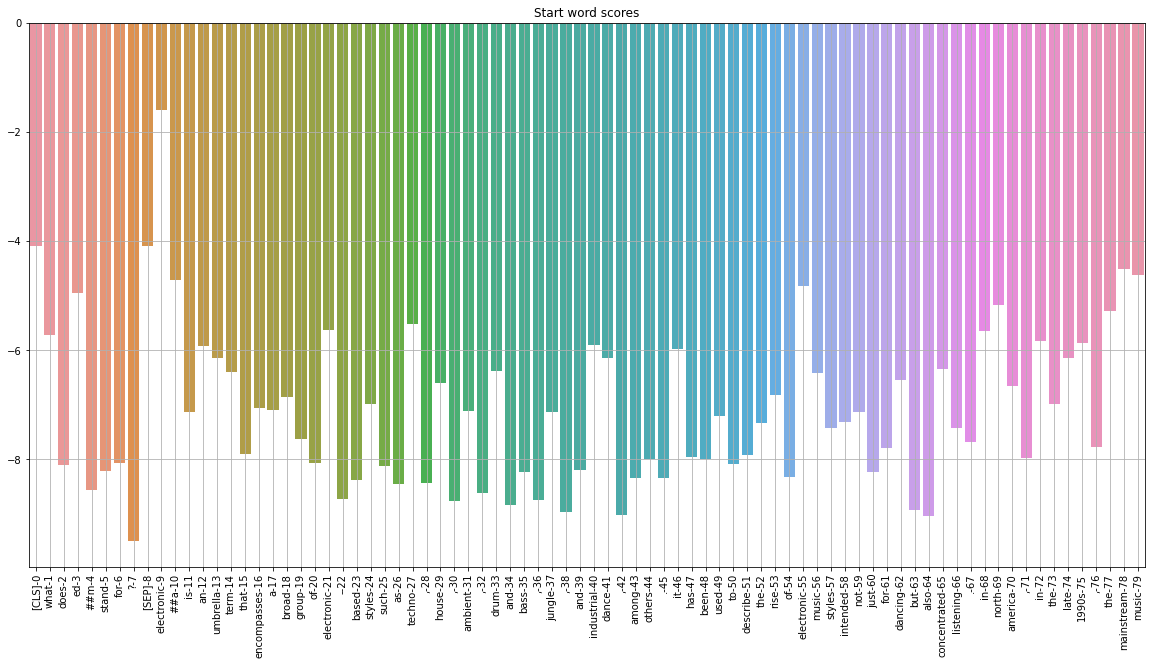

In [19]:
# #first 100 tokens
# plt.rcParams["figure.figsize"] = (20,10)
# ax = sns.barplot(x=token_labels[:80], y=start_scores[:80], ci=None)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# ax.grid(True)
# plt.title("Start word scores")
# plt.show()

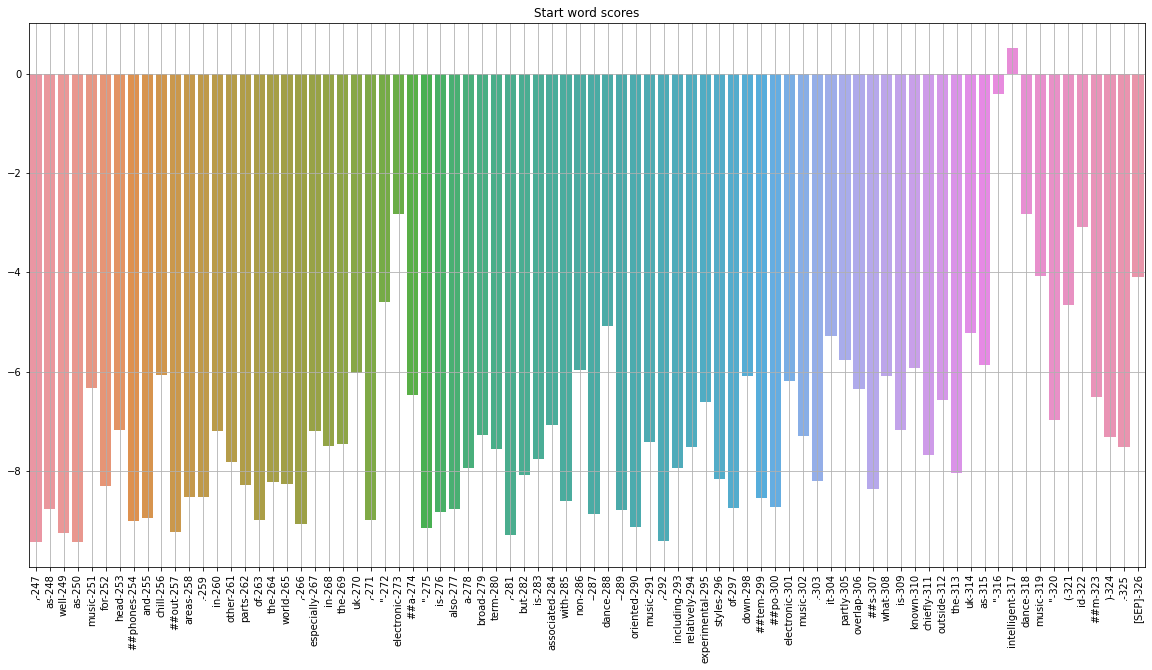

In [20]:
# #last 100 tokens
# plt.rcParams["figure.figsize"] = (20,10)
# ax = sns.barplot(x=token_labels[-80:], y=start_scores[-80:], ci=None)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# ax.grid(True)
# plt.title("Start word scores")
# plt.show()

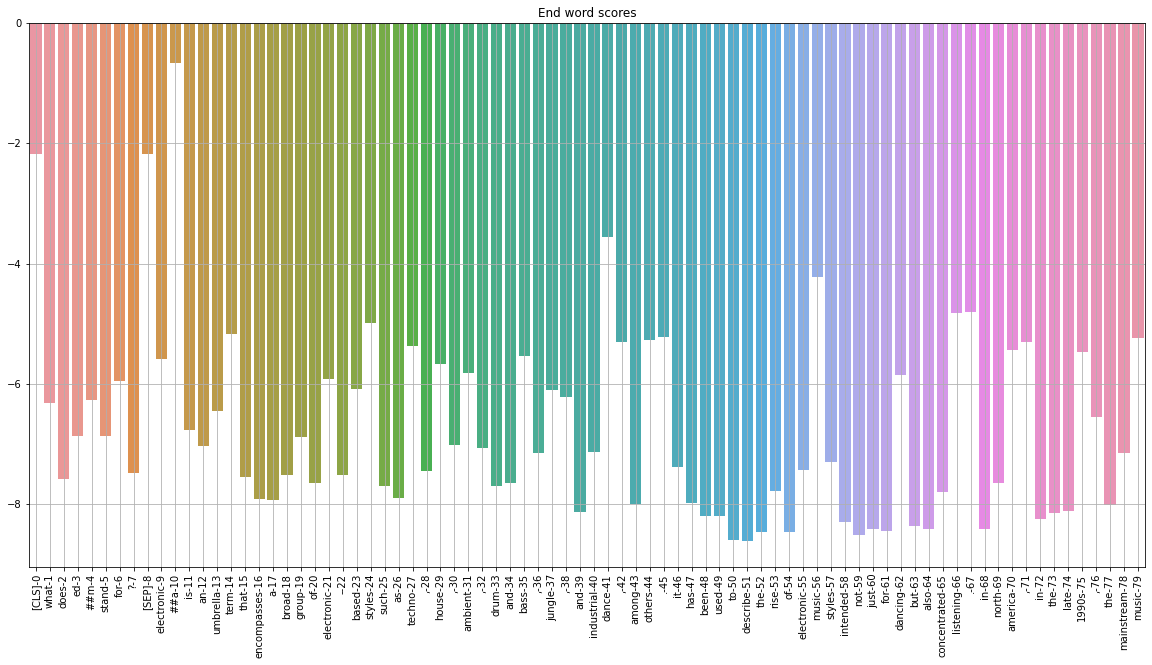

In [21]:
# #first 100 tokens
# plt.rcParams["figure.figsize"] = (20,10)
# ax = sns.barplot(x=token_labels[:80], y=end_scores[:80], ci=None)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# ax.grid(True)
# plt.title("End word scores")
# plt.show()

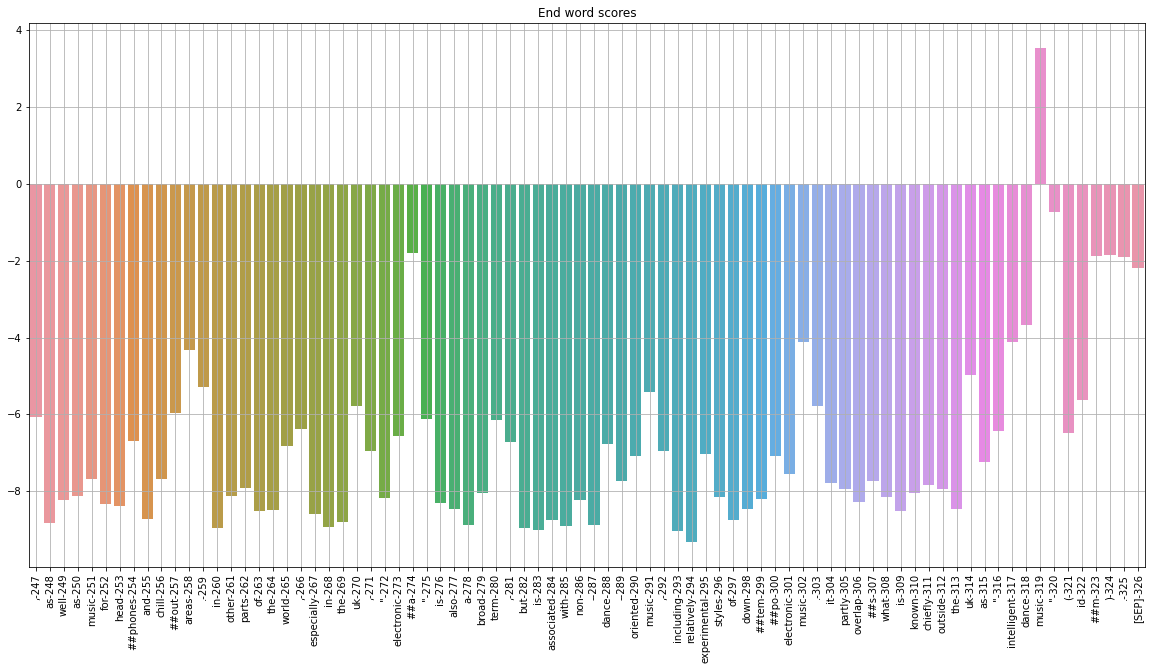

In [22]:
# #last 100 tokens
# plt.rcParams["figure.figsize"] = (20,10)
# ax = sns.barplot(x=token_labels[-80:], y=end_scores[-80:], ci=None)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
# ax.grid(True)
# plt.title("End word scores")
# plt.show()

### Code to join the broken words

In [23]:
answer = tokens[answer_start]

for i in range(answer_start+1, answer_end+1):
    if tokens[i][0:2] == "##":
        answer += tokens[i][2:]
    else:
        answer += " " + tokens[i]

### Function

In [24]:
def question_answer(question, text):
    
    #tokenize question and text in ids as a pair
    input_ids = tokenizer.encode(question, text)
    
    #string version of tokenized ids
    tokens = tokenizer.convert_ids_to_tokens(input_ids)
    
    #segment IDs
    #first occurence of [SEP] token
    sep_idx = input_ids.index(tokenizer.sep_token_id)

    #number of tokens in segment A - question
    num_seg_a = sep_idx+1

    #number of tokens in segment B - text
    num_seg_b = len(input_ids) - num_seg_a
    
    #list of 0s and 1s
    segment_ids = [0]*num_seg_a + [1]*num_seg_b
    
    assert len(segment_ids) == len(input_ids)
    
    #model output using input_ids and segment_ids
    output = model(torch.tensor([input_ids]), token_type_ids=torch.tensor([segment_ids]))
    
    #reconstructing the answer
    answer_start = torch.argmax(output.start_logits)
    answer_end = torch.argmax(output.end_logits)

    if answer_end >= answer_start:
        answer = tokens[answer_start]
        for i in range(answer_start+1, answer_end+1):
            if tokens[i][0:2] == "##":
                answer += tokens[i][2:]
            else:
                answer += " " + tokens[i]
                
    if answer.startswith("[CLS]"):
        answer = "Unable to find the answer to your question."
    
#     print("Text:\n{}".format(text.capitalize()))
#     print("\nQuestion:\n{}".format(question.capitalize()))
    print("\nAnswer:\n{}".format(answer.capitalize()))

In [25]:
# text = """New York (CNN) -- More than 80 Michael Jackson collectibles -- including the late pop star's famous rhinestone-studded glove from a 1983 performance -- were auctioned off Saturday, reaping a total $2 million. Profits from the auction at the Hard Rock Cafe in New York's Times Square crushed pre-sale expectations of only $120,000 in sales. The highly prized memorabilia, which included items spanning the many stages of Jackson's career, came from more than 30 fans, associates and family members, who contacted Julien's Auctions to sell their gifts and mementos of the singer. Jackson's flashy glove was the big-ticket item of the night, fetching $420,000 from a buyer in Hong Kong, China. Jackson wore the glove at a 1983 performance during \"Motown 25,\" an NBC special where he debuted his revolutionary moonwalk. Fellow Motown star Walter \"Clyde\" Orange of the Commodores, who also performed in the special 26 years ago, said he asked for Jackson's autograph at the time, but Jackson gave him the glove instead. "The legacy that [Jackson] left behind is bigger than life for me,\" Orange said. \"I hope that through that glove people can see what he was trying to say in his music and what he said in his music.\" Orange said he plans to give a portion of the proceeds to charity. Hoffman Ma, who bought the glove on behalf of Ponte 16 Resort in Macau, paid a 25 percent buyer's premium, which was tacked onto all final sales over $50,000. Winners of items less than $50,000 paid a 20 percent premium."""
# question = "Where was the Auction held?"

# question_answer(question, text)


Answer:
Hard rock cafe in new york ' s times square


In [26]:
# print("Original answer:\n", data.loc[data["question"] == question]["answer"].values[0])

Original answer:
 Hard Rock Cafe


### Playing with the chatbot

In [34]:
text = input("Please enter your text: \n")
question = input("\nPlease enter your question: \n")

while True:
    question_answer(question, text)
    question = input("\nPlease enter your question: \n")

    
    # flag = True
    # flag_N = False
    
    # while flag:
    #     response = input("\nDo you want to ask another question based on this text (Y/N)? ")
        # if response[0] == "Y":
            # flag = False
    #     elif response[0] == "N":
    #         print("\nBye!")
    #         flag = False
    #         flag_N = True
            
    # if flag_N == True:
    #     break


Answer:
Unable to find the answer to your question.


### Version checking

In [ ]:
torch.__version__